## Detailed information
We have customized twirling scheme, but as a comparison, we need the expectation value from circuits with full Pauli twirling for $\rm CNOT$. 

When I said "full Pauli twirling for $\rm CNOT$", it refers to the Pauli twirling scheme where
* the twirling set is $16$ Pauli operators for 2-qubit gates
* if the Pauli gate is $P$ before Clifford gate $U$, the the Pauli gate after Clifford gate is $UPU^{\dagger}$. For example
    * The Pauli gate before $\rm CNOT$ is $Z\otimes I$, the Pauli gate after $\rm CNOT$ is $Z\otimes I$
    * The Pauli gate before $\rm CNOT$ is $I\otimes Z$, the Pauli gate after $\rm CNOT$ is $Z\otimes Z$
    * The Pauli gate before $\rm CNOT$ is $X\otimes I$, the Pauli gate after $\rm CNOT$ is $X\otimes X$
    * The Pauli gate before $\rm CNOT$ is $I\otimes X$, the Pauli gate after $\rm CNOT$ is $I\otimes X$

Here I visualize some of my twirled circuit for your reference. Some details of my twirled circuits are seen below
* I have a circuit with parameter $\theta$, where $\theta$ is the rotating angle of $R_z(\theta)$ between the 5-th and 6-th $\rm CNOT$ gate.  
* I create circuit for $12$ different $\theta$. For each circuit, I create $60$ random samples.  
* I measure the expectation of $\langle X_3X_4\rangle$. I think using `Sampler` or `Estimator` do not make any difference to estimate the expectation value. 

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
import numpy as np
import pickle
import matplotlib.pyplot as plt

with open('twirled_circuit', 'rb') as file:
    twirled_circuit = pickle.load(file)

angle_list = {'pi_01': np.pi/6,    # 30 degrees
              'pi_02': np.pi/3,    # 60 degrees
              'pi_03': np.pi/2,    # 90 degrees
              'pi_04': 2*np.pi/3,  # 120 degrees
              'pi_05': 5*np.pi/6,  # 150 degrees
              'pi_06': np.pi,      # 180 degrees
              'pi_07': 7*np.pi/6,  # 210 degrees
              'pi_08': 4*np.pi/3,  # 240 degrees
              'pi_09': 3*np.pi/2,  # 270 degrees
              'pi_10': 5*np.pi/3,  # 300 degrees
              'pi_11': 11*np.pi/6} # 330 degrees 

print(f'There are {len(twirled_circuit['pi_03'])} twirled circuits for each angle. ')

60

### Two examples of twirled circuit

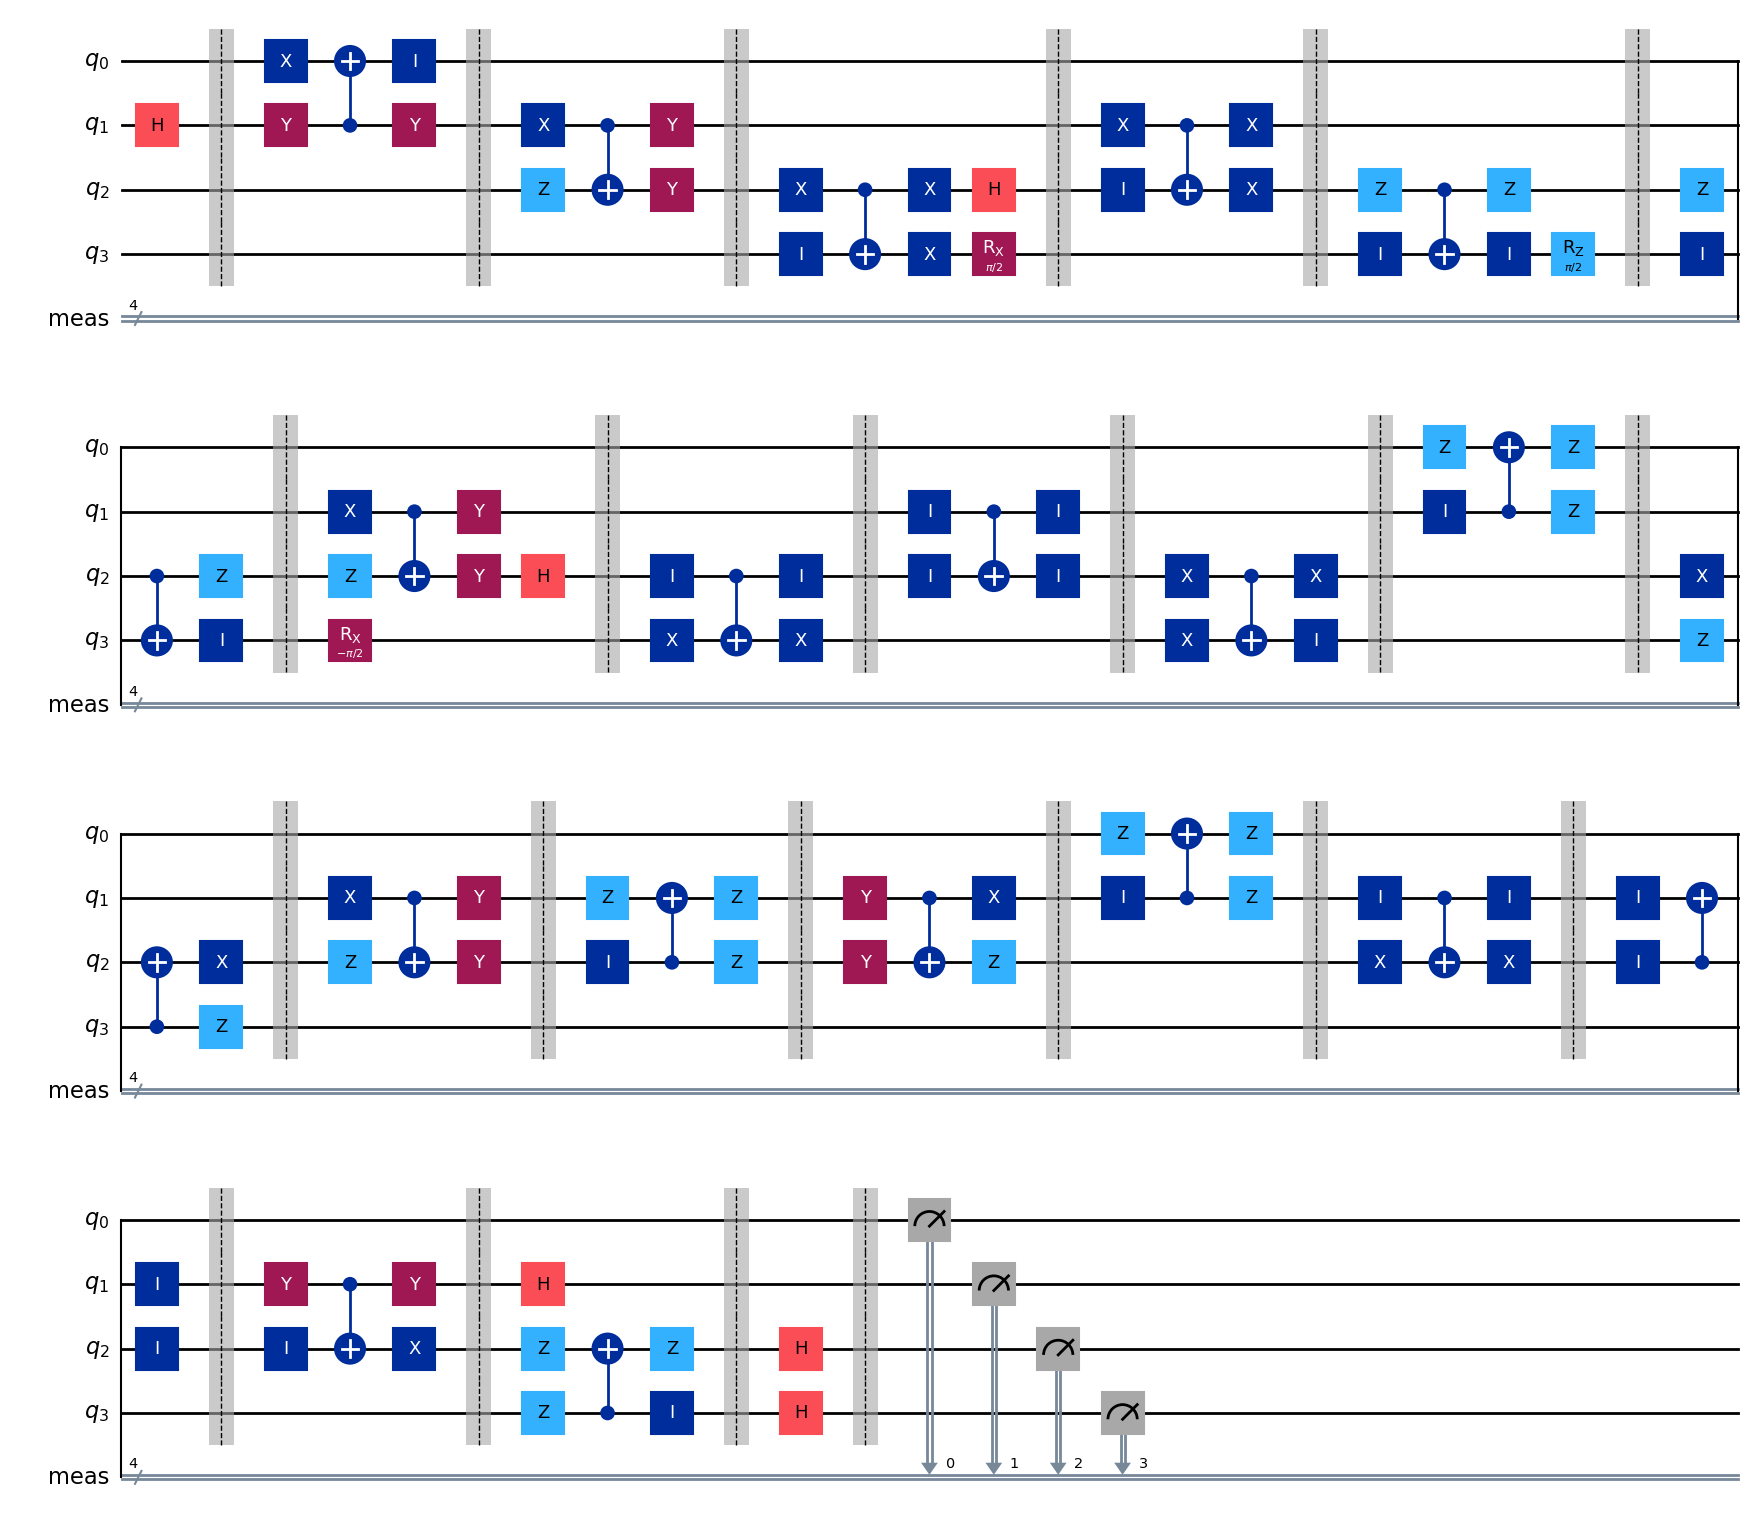

In [2]:
twirled_circuit['pi_03'][0].draw(output='mpl')

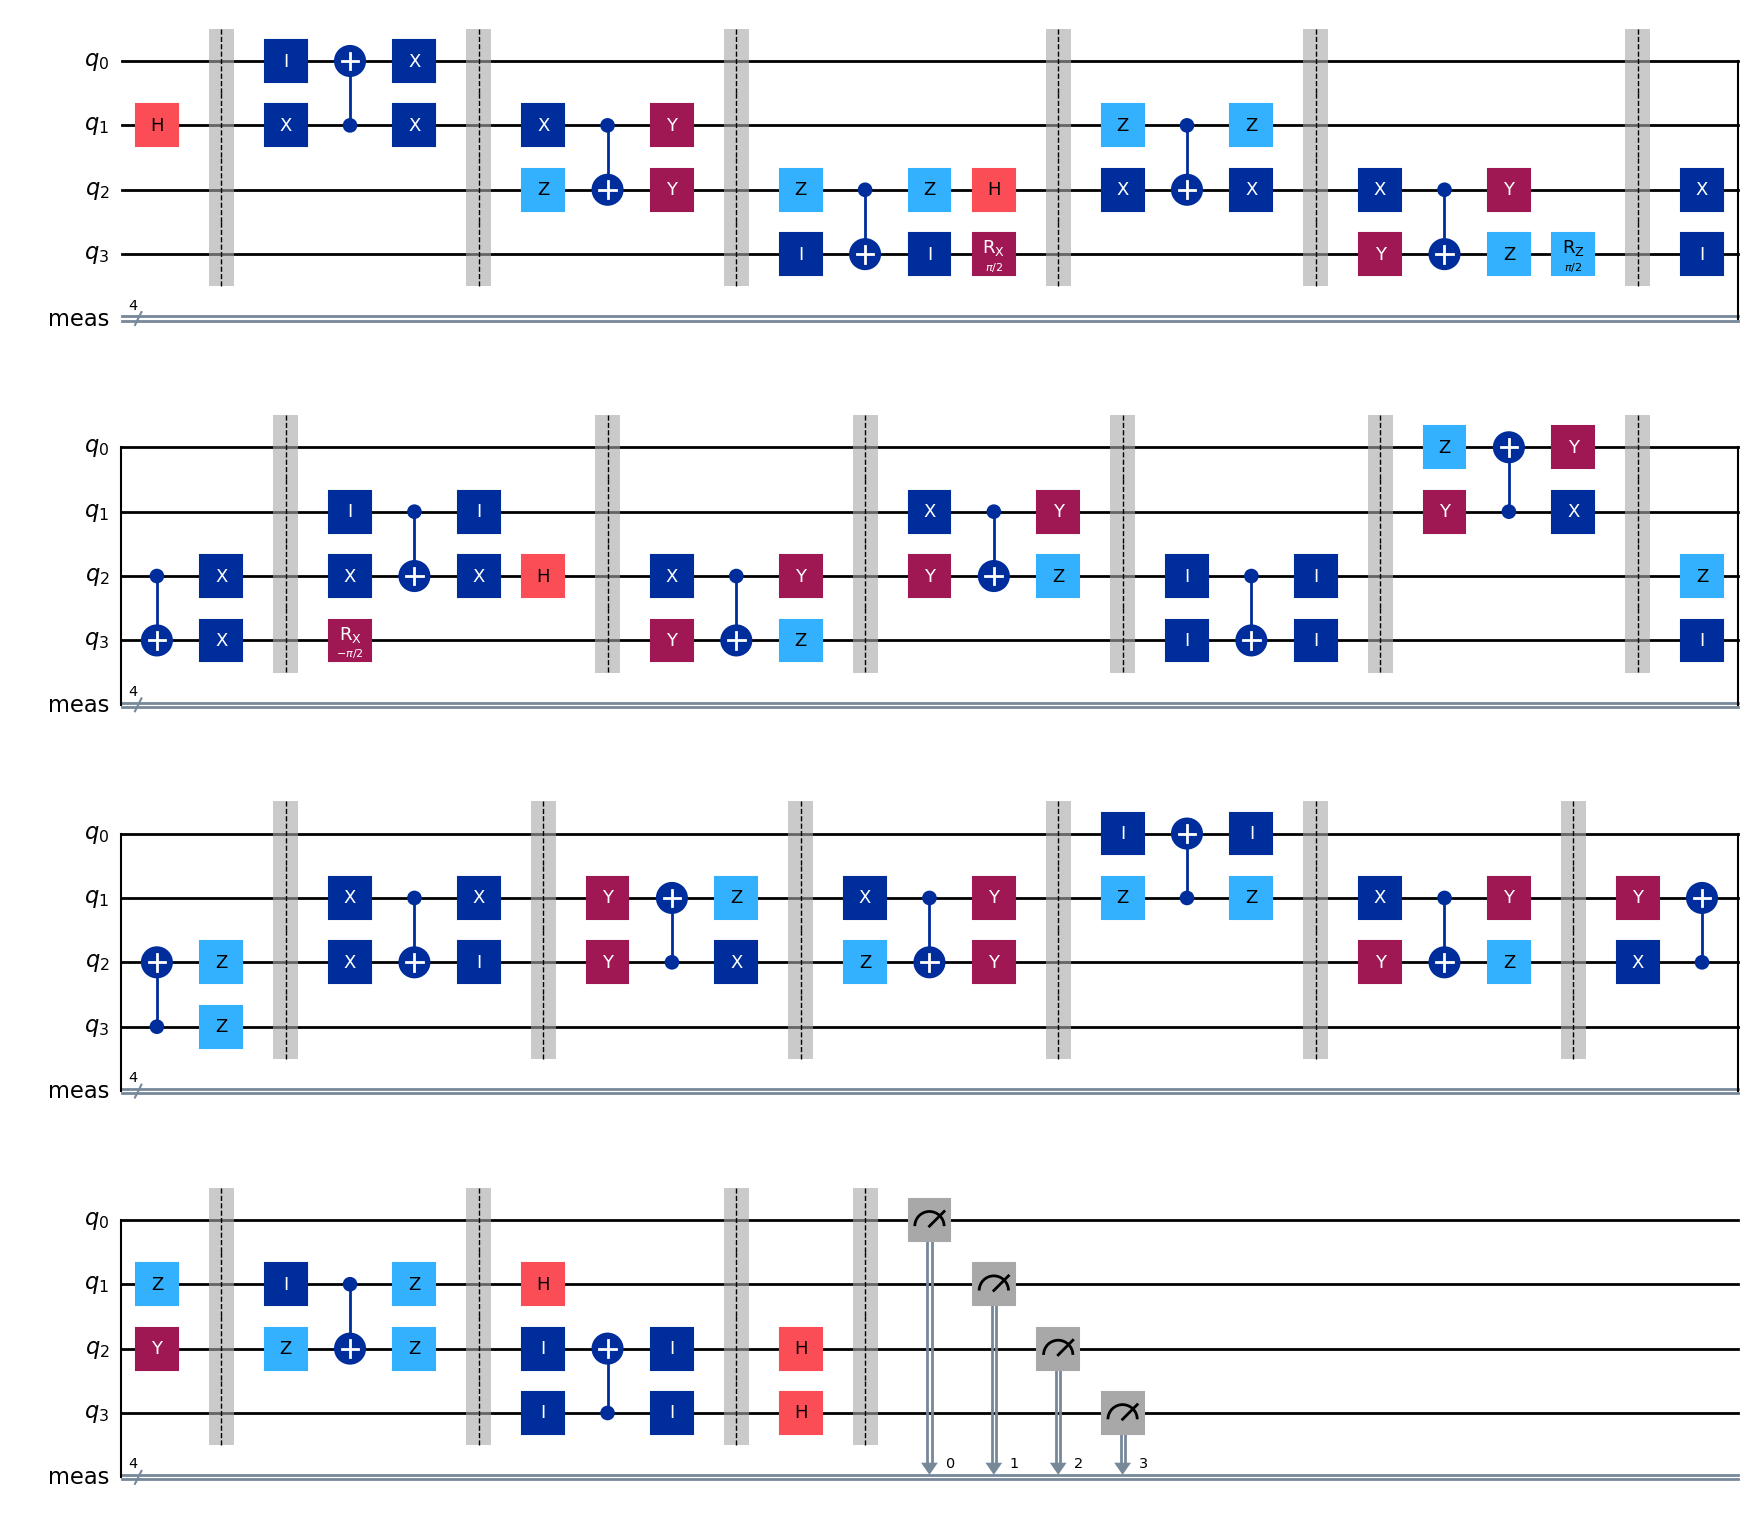

In [3]:
twirled_circuit['pi_03'][1].draw(output='mpl')

### Test Twirled Circuit on FakeBackend

I planned to run twirled circuits on `ibm_brussels` but there is no fake backend for this device. Then I decide to use the `FakeBrisbane` to simulate the circuit and test the Pauli twirling. The reasons why I choose `FakeBrisbane` and choose `ibm_brussels`
* both `ibm_brussels` and `ibm_brisbane` have same number of qubits and architecture, and the physical noise level of them are close. 
* `ibm_brussels` has a short queue so it is suitable to run a test of twirled circuits. 
* `FakeBrisbane` can be used to only test the twirled circuit. 

In [4]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='usc/difelice-researc/qcapp',
    token='c13885956d81ef600a9f4079b177a49858332dfbb08fecb4086694100c2172cca257194a4fdb6cb81166105c7812d53166522b9c8fffeb3f1531dfef4b9ff127'
)

backend_name = "ibm_brussels"
backend = service.backend(backend_name)
pm = generate_preset_pass_manager(backend = backend, 
                                  optimization_level = 0, 
                                  initial_layout = [70, 74, 89, 88])

device_backend = FakeBrisbane()
sim_127 = AerSimulator.from_backend(device_backend)

In [5]:
counts = {}

for angle_tag in angle_list.keys():
    tmp_circ = twirled_circuit[angle_tag]
    counts[angle_tag] = sim_127.run(pm.run(tmp_circ), shots=20000).result().get_counts()

In [6]:
def expectation_x1x2(count):
    exp = 0
    shots = 0
    for key, value in count.items():
        shots += value
        if key[0] == key[1]:  
            # X1X2, 00xx and 11xx are +1 
            exp += value 
        else:
            exp -= value  # 01xx and 10xx are -1 
            
    return exp / shots


x1x2 = []
angles = []
for angle_tag in angle_list.keys():
    angles.append(angle_list[angle_tag])
    tmp_count = counts[angle_tag]
    tmp_x1x2 = []
    for i in range(len(tmp_count)):
        tmp_x1x2.append(expectation_x1x2(tmp_count[i]))
    x1x2.append(np.mean(tmp_x1x2))

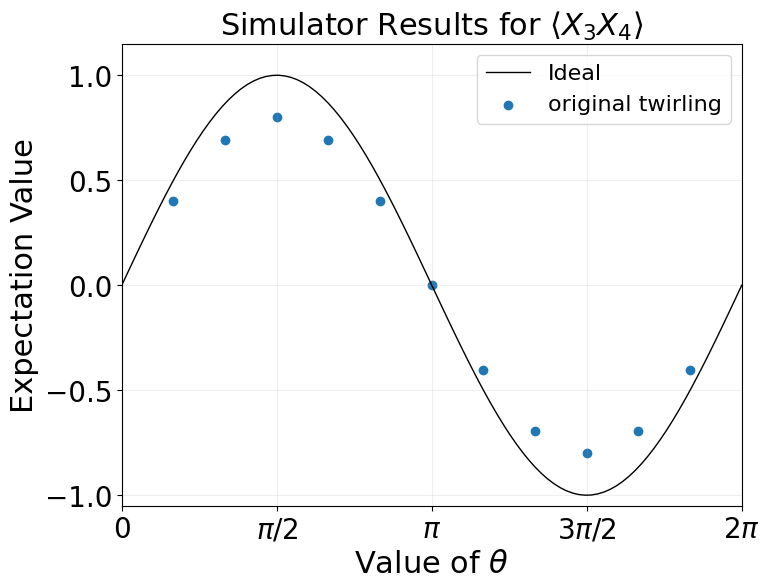

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axs.plot(np.linspace(0, 2*np.pi, 100), np.sin(np.linspace(0, 2*np.pi, 100)), 
            color = 'black', linewidth = 1, label = 'Ideal')
axs.scatter(angles, x1x2, marker='o', label='original twirling')
axs.set_title(r"Simulator Results for $\langle X_3X_4\rangle$", fontsize = 22)
axs.set_xticks([0, np.pi/2, np.pi, 3 * np.pi/2, 2 * np.pi])
axs.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
axs.set_xlim(0, 2 * np.pi)
axs.set_ylim(-1.05, 1.15)
axs.set_yticks([-1.0, -0.5, 0, 0.5, 1.0])
axs.set_xlabel(r"Value of $\theta$", fontsize = 22)
axs.set_ylabel(r"Expectation Value", fontsize = 22)
axs.grid(alpha = 0.2)
axs.tick_params(axis='x', labelsize=20)
axs.tick_params(axis='y', labelsize=20)
axs.legend(fontsize=16)